In [303]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KernelKMeans
from tslearn import metrics
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram


#Read and clean data
df = pd.read_csv('seasonal_data.csv', sep=';')
df = df.fillna(value=0)
# df['Overall'] = (df['Overall'] -df['Overall'].min())/(df['Overall'].max()-df['Overall'].min())

groups = df.groupby('Item').Overall.apply(np.array).reset_index()

#Convert to array
timeseries = list(groups.iloc[:,1])

In [146]:
df.columns

Index(['Item', 'Overall'], dtype='object')

In [304]:
from tsfresh import extract_features

extracted_features = extract_features(df, column_id="Item", column_value="Overall")

Feature Extraction: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


In [305]:
extracted_features = extracted_features.reset_index()
extracted_features = extracted_features.drop(['index'], axis=1)
x = extracted_features.mask(np.isinf(extracted_features))
x = x.interpolate(method = 'linear').ffill().bfill()
x = x.dropna(axis=1)

In [310]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(x)
x_normalized = pd.DataFrame(np_scaled, columns = x.columns)
pca = PCA(n_components=0.99)

pca.fit(x_normalized)
reduced_data = pca.transform(x_normalized)
reduced_data.shape

(433, 129)

In [311]:
x_normalized

,Overall__variance_larger_than_standard_deviation,Overall__has_duplicate_max,Overall__has_duplicate_min,Overall__has_duplicate,Overall__sum_values,Overall__abs_energy,Overall__mean_abs_change,Overall__mean_change,Overall__mean_second_derivative_central,Overall__median,...,Overall__permutation_entropy__dimension_5__tau_1,Overall__permutation_entropy__dimension_6__tau_1,Overall__permutation_entropy__dimension_7__tau_1,"Overall__matrix_profile__feature_""min""__threshold_0.98","Overall__matrix_profile__feature_""max""__threshold_0.98","Overall__matrix_profile__feature_""mean""__threshold_0.98","Overall__matrix_profile__feature_""median""__threshold_0.98","Overall__matrix_profile__feature_""25""__threshold_0.98","Overall__matrix_profile__feature_""75""__threshold_0.98",Overall__mean_n_absolute_max__number_of_maxima_7
0,0.633478,-0.604922,-1.345990,0.0,0.601133,-0.394607,-0.284850,-0.384030,0.451464,1.675736,...,0.771492,0.795458,0.754157,-0.793193,-0.894809,-0.911524,-0.868172,-0.828826,-0.973190,-0.487859
1,0.633478,-0.604922,-1.345990,0.0,0.601585,-0.374436,-0.179356,-0.510694,0.479254,1.593268,...,0.831340,0.778230,0.754157,-0.793193,-0.894809,-0.911524,-0.868172,-0.828826,-0.973190,-0.331030
2,0.633478,-0.604922,-1.345990,0.0,0.601133,-0.392868,-0.447185,-0.863891,0.532696,1.378849,...,0.651796,0.726547,0.754157,-0.793193,-0.894809,-0.911524,-0.868172,-0.828826,-0.973190,-0.367990
3,0.633478,-0.604922,-1.345990,0.0,0.602038,-0.375797,-0.585277,-0.320698,0.296838,1.477811,...,0.817963,0.795458,0.754157,-0.793193,-0.894809,-0.911524,-0.868172,-0.828826,-0.973190,-0.243792
4,0.633478,-0.604922,-1.345990,0.0,0.601359,-0.370121,-0.404595,-0.332878,0.326053,1.560280,...,0.729364,0.726547,0.736664,-0.793193,-0.894809,-0.911524,-0.868172,-0.828826,-0.973190,-0.260108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,-1.578587,1.653106,0.742948,0.0,-1.662894,-0.534885,-1.275081,-0.099037,0.425812,-1.144698,...,-1.499890,-1.513736,-1.529295,0.395848,0.147286,0.359822,0.225599,0.452389,0.501259,-1.346257
429,-1.578587,1.653106,0.742948,0.0,-1.662894,-0.534885,-1.275081,-0.099037,0.425812,-1.144698,...,-1.499890,-1.513736,-1.529295,0.066151,-0.050050,0.064013,-0.060628,0.131176,0.266124,-1.346257
430,-1.578587,1.653106,0.742948,0.0,-1.662894,-0.534885,-1.275081,-0.099037,0.425812,-1.144698,...,-1.499890,-1.513736,-1.529295,-0.263545,-0.247385,-0.231796,-0.346856,-0.190038,0.030990,-1.346257
431,0.633478,-0.604922,-1.345990,0.0,0.600906,-0.360166,-0.294678,-0.320698,0.445051,1.164430,...,0.760460,0.743775,0.754157,-0.593242,-0.444721,-0.527605,-0.633084,-0.511251,-0.204144,-0.131581


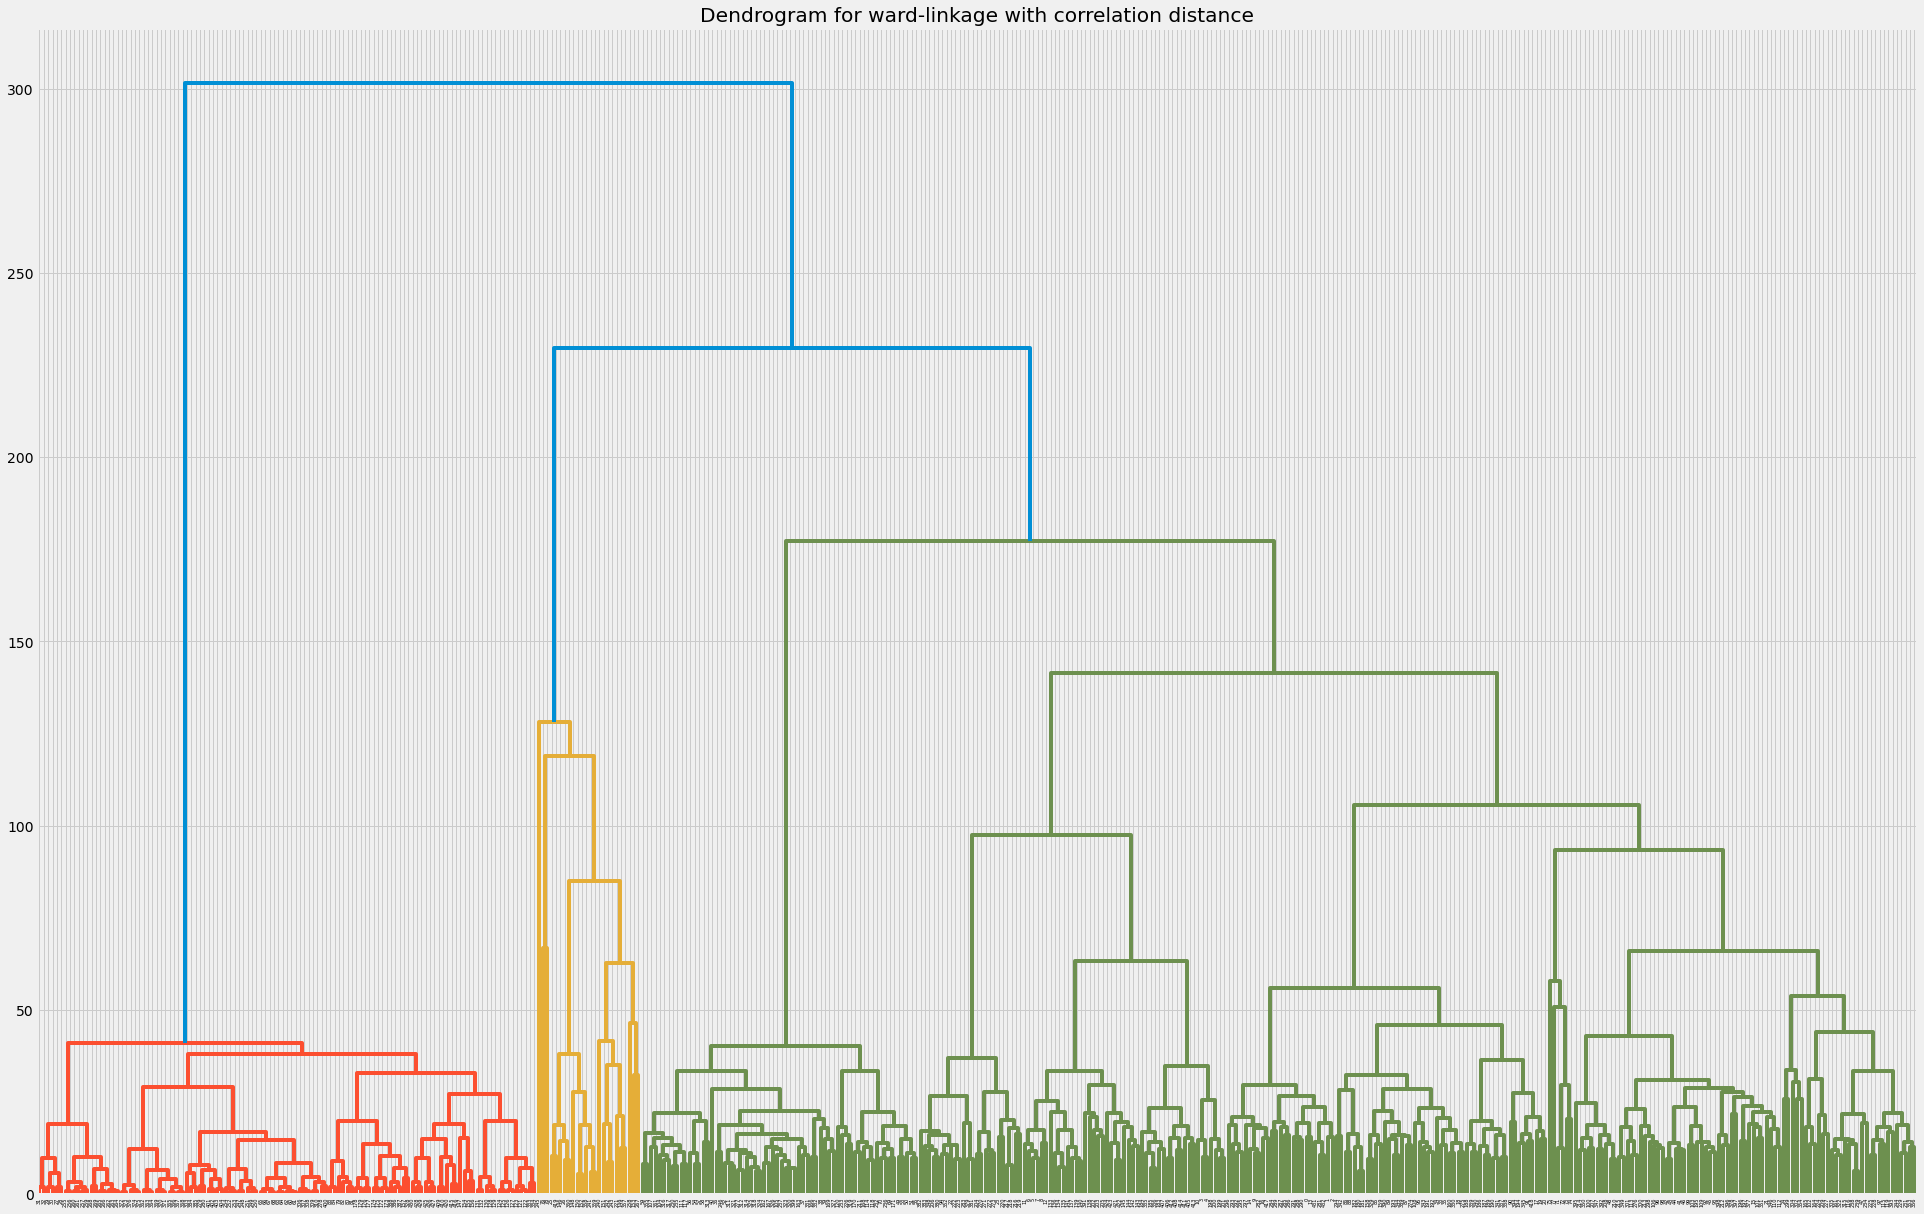

In [339]:
import matplotlib.pyplot as plt

def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(30, 20))
    dn = dendrogram(Z, truncate_mode='level')
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.savefig('dendrogram.png')
    plt.show()
    
    return Z

d = dtw.distance_matrix_fast(reduced_data)

linkage_matrix = hierarchical_clustering(reduced_data)

In [340]:
from scipy.cluster.hierarchy import fcluster

# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 80 , criterion='distance')
print(np.unique(cluster_labels))



[ 1  2  3  4  5  6  7  8  9 10 11]


In [341]:
df = pd.DataFrame({'x':cluster_labels})
df.value_counts()

x 
1     115
11     79
9      74
6      64
8      47
7      24
3      11
4      10
10      6
2       2
5       1
dtype: int64

In [318]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

sse = []
chs = []
dbs = []
labels = []
for i in range(2,25):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(reduced_data)
    labels.append(kmeans.labels_)
    score_ss = silhouette_score(reduced_data, kmeans.labels_)
    score_ch = calinski_harabasz_score(reduced_data, kmeans.labels_)
    score_db = davies_bouldin_score(reduced_data, kmeans.labels_)
    sse.append(score_ss)
    chs.append(score_ch)
    dbs.append(score_db)


In [332]:
chs

[126.31100979519948,
 120.1595812148045,
 114.6900903065606,
 104.6638913944397,
 98.5037627079808,
 93.67311382379295,
 87.11353216026566,
 85.76798838396063,
 81.09042962839068,
 79.92259566132466,
 76.18739084836565,
 71.9359044962677,
 69.01175237213165,
 67.93752009953515,
 65.51110263692395,
 63.4123685712975,
 62.264412404857225,
 59.439634010396375,
 57.22713273198131,
 54.99447498550649,
 53.60271223597502,
 52.283628670723644,
 51.74386838919278]

In [342]:
(unique, counts) = np.unique(labels[9], return_counts=True)
frequencies = np.asarray((unique, counts)).T

frequencies

array([[  0,   6],
       [  1,  74],
       [  2, 115],
       [  3,  15],
       [  4,   2],
       [  5,  47],
       [  6,  74],
       [  7,  24],
       [  8,   1],
       [  9,  69],
       [ 10,   6]], dtype=int64)

In [346]:
df2 = pd.DataFrame({'x':labels[9] }) 
groups['kmeans'] = df2['x']
groups['hierarchical_clustering'] = df['x']
final = groups.drop('Overall', axis=1)

In [347]:
final.to_csv('test.csv')

In [258]:
x.mean()

Overall__variance_larger_than_standard_deviation         0.000000
Overall__has_duplicate_max                               0.267898
Overall__has_duplicate_min                               0.644342
Overall__has_duplicate                                   1.000000
Overall__sum_values                                      8.096008
                                                           ...   
Overall__matrix_profile__feature_"25"__threshold_0.98    2.188813
Overall__matrix_profile__feature_"75"__threshold_0.98    3.144035
Overall__mean_n_absolute_max__number_of_maxima_7         0.184067
clusters                                                 8.581986
cluster                                                  8.581986
Length: 498, dtype: float64